In [1]:
import os
import sys
from  dotenv import load_dotenv
import psycopg2
import pandas as pd 
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [3]:
load_dotenv()
user = os.environ['user']
password = os.environ['password']
host = os.environ['host']
port = os.environ['port']
database = os.environ['database']

In [4]:
def connect():
    conn = None
    try:
        print('Connecting...')
        conn = psycopg2.connect(
            host = host,
            database = database,
            user = user,
            password = password
        )
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        sys.exit(1)

    print("All good, Connection successfull!")
    return conn

In [5]:
def sql_dataFrame(conn, query):
    cursor = conn.cursor()
    try:
        cursor.execute(query)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return 1
    tuples_list = cursor.fetchall()

    df = pd.DataFrame(tuples_list, columns=[col[0] for col in cursor.description])
    cursor.close()
    return df

In [6]:
query = """ SELECT * FROM public.xdr_data"""

conn = connect()

df = sql_dataFrame(conn, query)

conn.close()

Connecting...
All good, Connection successfull!


In [7]:
df.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [8]:

import warnings
warnings.filterwarnings('ignore')

In [2]:
def replace_outliers_with_mean(column):
    
    mean = column.mean()
    std = column.std()
    column[np.abs(column - mean) > 3 * std] = mean

In [ ]:
replace_outliers_with_mean(df['avg_tcp_retransmission'])
replace_outliers_with_mean(df['avg_rtt'])
replace_outliers_with_mean(df['avg_throughput'])

In [ ]:
grouped_df = df.groupby('MSISDN/Number').agg({
    'avg_tcp_retransmission': 'mean',
    'avg_rtt': 'mean',
    'Handset Type': lambda x: x.mode()[0],
    'avg_throughput': 'mean'
})

grouped_df

,avg_tcp_retransmission,avg_rtt,Handset Type,avg_throughput
MSISDN/Number,,,,
3.360100e+10,1.285848e+07,23.000000,Huawei P20 Lite Huawei Nova 3E,38.0
3.360100e+10,1.285848e+07,15.500000,Apple iPhone 7 (A1778),49.5
3.360100e+10,1.285848e+07,63.512443,undefined,48.5
3.360101e+10,1.285848e+07,42.000000,Apple iPhone 5S (A1457),124.0
3.360101e+10,8.771950e+06,29.750000,Apple iPhone Se (A1723),14211.0
...,...,...,...,...
3.379000e+10,1.090225e+05,26.000000,Huawei Honor 9 Lite,5182.5
3.379000e+10,1.285848e+07,20.000000,Apple iPhone 8 Plus (A1897),58.0
3.197021e+12,1.285848e+07,63.512443,Quectel Wireless. Quectel Ec25-E,0.5


In [ ]:
df['avg_tcp_retransmission'] = (df['TCP DL Retrans. Vol (Bytes)'] + df['TCP UL Retrans. Vol (Bytes)']) / 2
df['avg_tcp_retransmission']

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
149996   NaN
149997   NaN
149998   NaN
149999   NaN
150000   NaN
Name: avg_tcp_retransmission, Length: 150001, dtype: float64

In [ ]:
df['avg_tcp_retransmission'].isnull().sum()

99530

In [ ]:
df['avg_tcp_retransmission'].fillna(df['avg_tcp_retransmission'].mean(), inplace=True)

In [ ]:
df['avg_tcp_retransmission'].isnull().sum()

0

In [ ]:
df['avg_rtt'] = (df['Avg RTT DL (ms)'] + df['Avg RTT UL (ms)']) / 2
df['avg_rtt']

0         23.5
1         35.0
2          NaN
3          NaN
4          NaN
          ... 
149996    16.0
149997    14.5
149998    24.5
149999    21.0
150000     NaN
Name: avg_rtt, Length: 150001, dtype: float64

In [ ]:
df['avg_rtt'].fillna(df['avg_rtt'].mean(), inplace=True)
df['avg_rtt']

0         23.500000
1         35.000000
2         63.512443
3         63.512443
4         63.512443
            ...    
149996    16.000000
149997    14.500000
149998    24.500000
149999    21.000000
150000    63.512443
Name: avg_rtt, Length: 150001, dtype: float64

In [ ]:
handset_type = df.groupby('MSISDN/Number').agg({'Handset Type': lambda x: x.mode()[0]})

handset_type

,Handset Type
MSISDN/Number,
3.360100e+10,Huawei P20 Lite Huawei Nova 3E
3.360100e+10,Apple iPhone 7 (A1778)
3.360100e+10,undefined
3.360101e+10,Apple iPhone 5S (A1457)
3.360101e+10,Apple iPhone Se (A1723)
...,...
3.379000e+10,Huawei Honor 9 Lite
3.379000e+10,Apple iPhone 8 Plus (A1897)
3.197021e+12,Quectel Wireless. Quectel Ec25-E


In [ ]:
df['avg_throughput'] = (df['Avg Bearer TP DL (kbps)'] + df['Avg Bearer TP UL (kbps)']) / 2
df['avg_throughput']

0         33.5
1         21.0
2          7.5
3         44.0
4          7.5
          ... 
149996    58.5
149997    38.5
149998    45.0
149999    35.5
150000     NaN
Name: avg_throughput, Length: 150001, dtype: float64

In [ ]:
df['avg_throughput'].fillna(df['avg_throughput'].mean(), inplace=True)
df['avg_throughput']

0           33.500000
1           21.000000
2            7.500000
3           44.000000
4            7.500000
             ...     
149996      58.500000
149997      38.500000
149998      45.000000
149999      35.500000
150000    7535.237287
Name: avg_throughput, Length: 150001, dtype: float64

In [ ]:
top10_tcp = df.nlargest(10, 'avg_tcp_retransmission')['avg_tcp_retransmission']
bottom10_tcp = df.nsmallest(10, 'avg_tcp_retransmission')['avg_tcp_retransmission']
most_frequent_tcp = df['avg_tcp_retransmission'].value_counts().head(10)

print('top10_tcp',top10_tcp)
print('bottom10_tcp',bottom10_tcp)
print('most_frequent_tcp',most_frequent_tcp)

top10_tcp 34645     2.172058e+09
140813    2.150739e+09
77979     2.147216e+09
135678    2.145732e+09
3782      2.144060e+09
119684    2.137746e+09
39637     2.134324e+09
59016     2.130808e+09
76990     2.130087e+09
41209     2.127330e+09
Name: avg_tcp_retransmission, dtype: float64
bottom10_tcp 143594    43.0
111113    48.5
18432     53.0
13157     54.0
97070     56.5
8816      64.0
99959     64.5
83227     67.0
95966     67.0
12866     71.5
Name: avg_tcp_retransmission, dtype: float64
most_frequent_tcp avg_tcp_retransmission
1.285848e+07    99530
1.330000e+03       29
2.660000e+03       24
3.325000e+03       20
1.995000e+03       19
3.990000e+03       14
9.365000e+02       13
1.324000e+03        9
7.980000e+03        9
5.320000e+03        8
Name: count, dtype: int64


In [ ]:
top10_rtt = df.nlargest(10, 'avg_rtt')['avg_rtt']
bottom10_rtt = df.nsmallest(10, 'avg_rtt')['avg_rtt']
most_frequent_rtt = df['avg_rtt'].value_counts().head(10)

print('top10_rtt :',top10_rtt)
print('bottom10_rtt',bottom10_rtt)
print('most_frequent_rtt',most_frequent_rtt)

NameError: name 'df' is not defined

In [ ]:
top10_throughput = df.nlargest(10, 'avg_throughput')['avg_throughput']
bottom10_throughput = df.nsmallest(10, 'avg_throughput')['avg_throughput']
most_frequent_throughput = df['avg_throughput'].value_counts().head(10)

print('top10_throughput',top10_throughput)
print('bottom10_throughput',bottom10_throughput)
print('most_frequent_throughput',most_frequent_throughput)

top10_throughput 120890    191131.0
143670    156622.0
141262    152149.5
91313     150273.0
116807    141965.5
141458    140572.0
149617    138576.0
92193     138102.5
116565    137026.0
117791    134944.0
Name: avg_throughput, dtype: float64
bottom10_throughput 149     0.0
364     0.0
618     0.0
756     0.0
1818    0.0
2489    0.0
3935    0.0
4166    0.0
4853    0.0
5821    0.0
Name: avg_throughput, dtype: float64
most_frequent_throughput avg_throughput
31.5    3886
7.5     3741
48.5    1945
45.0    1885
49.0    1801
48.0    1671
49.5    1571
44.5    1557
45.5    1520
46.5    1491
Name: count, dtype: int64


In [ ]:
throughput_per_handset = df.groupby('Handset Type')['avg_throughput'].mean()
throughput_per_handset

Handset Type
A-Link Telecom I. Cubot A5                                                             11755.000000
A-Link Telecom I. Cubot Note Plus                                                       3349.500000
A-Link Telecom I. Cubot Note S                                                          4468.500000
A-Link Telecom I. Cubot Nova                                                           28108.500000
A-Link Telecom I. Cubot Power                                                          34734.000000
                                                                                           ...     
Zte Zte Blade C2 Smartphone Android By Sfr Startrail 4 Zte Blade Flex T809 Zte T809       29.000000
Zyxel Communicat. Lte7460                                                              30978.000000
Zyxel Communicat. Sbg3600                                                              48675.500000
Zyxel Communicat. Zyxel Wah7706                                                        

In [ ]:
top10_throughput_per_handset=throughput_per_handset.nlargest(10)
top10_throughput_per_handset

Handset Type
Huawei B715S-23C               54497.115385
New-Bund Technol. Mix 2        52605.500000
Lg G6+                         50067.500000
Zyxel Communicat. Sbg3600      48675.500000
Huawei Y9 2019                 45869.500000
Xiaomi Communica. M1902F1G     42806.833333
Spa Condor Elect. Allure M2    42155.750000
Ovvi-Cellphone T. Echo         39476.500000
Huawei Pele                    39190.500000
Spa Condor Elect. Plume L2     38264.500000
Name: avg_throughput, dtype: float64

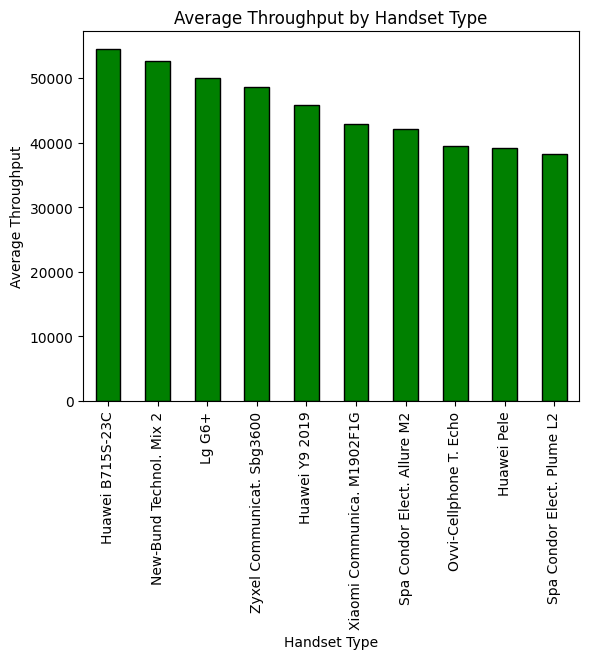

In [ ]:
top10_throughput_per_handset.plot(kind='bar',color ='green',ec ='black')

plt.xlabel('Handset Type')
plt.ylabel('Average Throughput')
plt.title('Average Throughput by Handset Type')
plt.show()

In [ ]:
tcp_per_handset = df.groupby('Handset Type')['avg_tcp_retransmission'].mean()
tcp_per_handset 

Handset Type
A-Link Telecom I. Cubot A5                                                             1.285848e+07
A-Link Telecom I. Cubot Note Plus                                                      3.081065e+05
A-Link Telecom I. Cubot Note S                                                         2.070587e+07
A-Link Telecom I. Cubot Nova                                                           6.858500e+04
A-Link Telecom I. Cubot Power                                                          4.020500e+03
                                                                                           ...     
Zte Zte Blade C2 Smartphone Android By Sfr Startrail 4 Zte Blade Flex T809 Zte T809    1.285848e+07
Zyxel Communicat. Lte7460                                                              2.063827e+07
Zyxel Communicat. Sbg3600                                                              2.674347e+07
Zyxel Communicat. Zyxel Wah7706                                                        

In [ ]:
top10_tcp_per_handset = tcp_per_handset.nlargest(10)
print(top10_tcp_per_handset)

Handset Type
Huawei Bln-Al10                              1.645873e+08
Asustek Asus Zenfone Selfie Zd551Kl          1.608292e+08
Samsung Galaxy Tab S3 (Sm-T825)              1.038853e+08
Huawei E5776S-32                             8.611504e+07
Apple iPad Pro (A1652)                       6.917633e+07
Samsung Galaxy J8 2018                       5.787917e+07
Dynamic Tech Hol. D-Mobile I3 I5 I7 I8 I9    5.329110e+07
Xiaomi Communica. Mi 6                       3.769354e+07
Huawei E5573                                 3.493472e+07
Huawei Y7 Prime 2018                         3.265211e+07
Name: avg_tcp_retransmission, dtype: float64


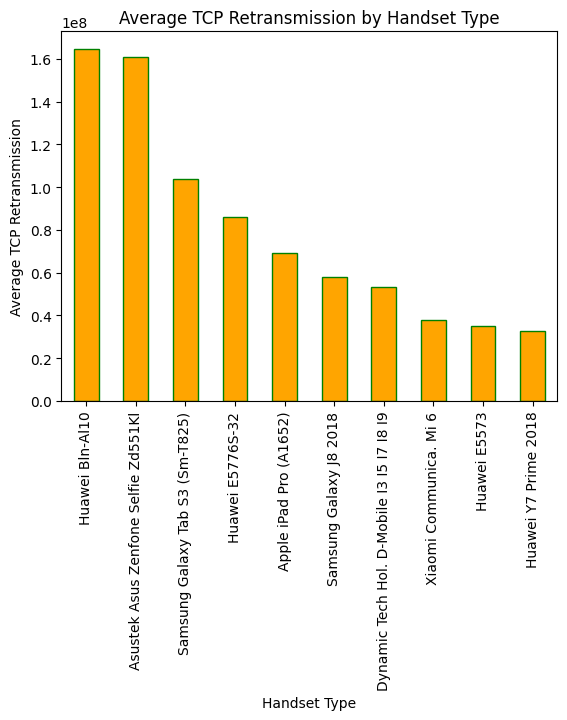

In [ ]:
top10_tcp_per_handset.plot(kind='bar',color ='orange',ec= 'green')


plt.xlabel('Handset Type')
plt.ylabel('Average TCP Retransmission')
plt.title('Average TCP Retransmission by Handset Type')
plt.show()

In [ ]:
print(df.isna().sum())

Bearer Id                                      991
Start                                            1
Start ms                                         1
End                                              1
End ms                                           1
Dur. (ms)                                        1
IMSI                                           570
MSISDN/Number                                 1066
IMEI                                           572
Last Location Name                            1153
Avg RTT DL (ms)                              27829
Avg RTT UL (ms)                              27812
Avg Bearer TP DL (kbps)                          1
Avg Bearer TP UL (kbps)                          1
TCP DL Retrans. Vol (Bytes)                  88146
TCP UL Retrans. Vol (Bytes)                  96649
DL TP < 50 Kbps (%)                            754
50 Kbps < DL TP < 250 Kbps (%)                 754
250 Kbps < DL TP < 1 Mbps (%)                  754
DL TP > 1 Mbps (%)             

In [ ]:
df.fillna(df[['avg_tcp_retransmission','avg_rtt','avg_throughput' ]].mean(), inplace=True)
df.head(5)

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes),avg_tcp_retransmission,avg_rtt,avg_throughput,cluster
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0,1.285848e+07,23.500000,33.5,0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0,1.285848e+07,35.000000,21.0,0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0,1.285848e+07,63.512443,7.5,0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0,1.285848e+07,63.512443,44.0,0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0,1.285848e+07,63.512443,7.5,0


In [ ]:
scaler = MinMaxScaler()
normalized_df = pd.DataFrame(scaler.fit_transform(df[['avg_tcp_retransmission', 'avg_rtt', 'avg_throughput']]),      
                             columns=['avg_tcp_retransmission', 'avg_rtt', 'avg_throughput'], index=df.index)
normalized_df

NameError: name 'pd' is not defined

In [ ]:
kmeans = KMeans(n_clusters=3)

kmeans.fit(normalized_df)
df['cluster'] = kmeans.labels_
df['cluster']

NameError: name 'KMeans' is not defined

In [ ]:
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
for i in range(3):
    cluster_df = df[df['cluster'] == i]
    
    print(f'Cluster {i}:')
    print(f'  Size: {len(cluster_df)}')
    print(f'  Average TCP Retransmission: {cluster_df["avg_tcp_retransmission"].mean()}')
    print(f'  Average RTT: {cluster_df["avg_rtt"].mean()}')
    print(f'  Average Throughput: {cluster_df["avg_throughput"].mean()}')

Cluster 0:
  Size: 111672
  Average TCP Retransmission: 11487086.851181101
  Average RTT: 65.94723634799703
  Average Throughput: 1052.5629812064499
Cluster 1:
  Size: 8310
  Average TCP Retransmission: 46526325.709796414
  Average RTT: 48.651385372153584
  Average Throughput: 47955.50517448857
Cluster 2:
  Size: 30019
  Average TCP Retransmission: 8640048.110163702
  Average RTT: 58.5688101530153
  Average Throughput: 20461.74312935141


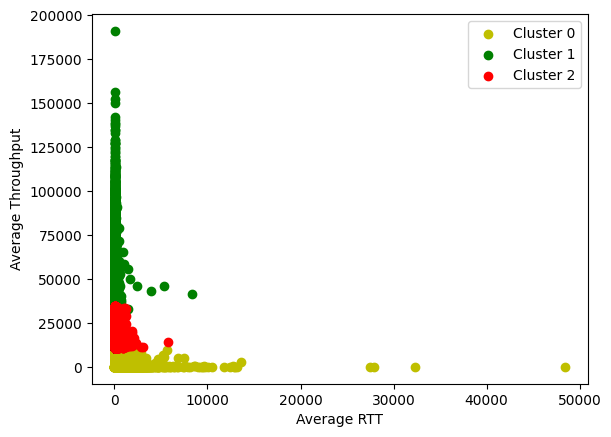

In [ ]:
fig, ax = plt.subplots()

colors = ['y', 'g', 'r']

for i in range(3):
    cluster_df = df[df['cluster'] == i]
    x = cluster_df['avg_rtt']
    y = cluster_df['avg_throughput']
    ax.scatter(x, y, c=colors[i], label=f'Cluster {i}')

ax.set_xlabel('Average RTT')
ax.set_ylabel('Average Throughput')
ax.legend()
plt.show()